In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from skimage import exposure 
from skimage.exposure import match_histograms
import pandas as pd
from pathlib import Path
import concurrent.futures
import tifffile
import matplotlib.pyplot as plt

In [2]:
IMGS_DIR = "./Original dataset/images"
img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))

In [ ]:
OUTPUT_DIR = "./PCS"
#print(img_paths)
for i, img_path in enumerate(img_paths):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    img = cv2.imread(img_path)
    r, c, d = img.shape
    data = img.reshape((r * c), d)
    print(data.shape)
    pca = PCA(1).fit(data) 
    img_transformed = pca.transform(data).reshape(r,c) 
    panchromatic=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    matched = match_histograms(img_transformed,panchromatic) 
    out_img_path = os.path.join(OUTPUT_DIR, img_filename)
    cv2.imwrite(out_img_path, matched)
    print(matched.shape)

In [5]:
import glob
import os

import cv2

IMGS_DIR = "./PCS"
MASKS_DIR = "./Original Dataset/masks"
OUTPUT_DIR_I = "./PCS_Split"
OUTPUT_DIR_M="./Mask_Split"

TARGET_SIZE = 500

img_paths = glob.glob(os.path.join(IMGS_DIR, "*.png"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()

os.makedirs(OUTPUT_DIR_I)
os.makedirs(OUTPUT_DIR_M)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(OUTPUT_DIR_I, "{}_{}.png".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(OUTPUT_DIR_M, "{}_{}.png".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)

            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

In [54]:
DATA_DIR = './'

In [55]:
img_subdir = Path(DATA_DIR) / 'PCS_Split'
mask_subdir = Path(DATA_DIR) / 'Mask_Split'

In [56]:
image_paths = list(img_subdir.glob('*png'))
mask_paths = [mask_subdir / path.name for path in image_paths]

image_paths = [str(path) for path in image_paths]
mask_paths = [str(path) for path in mask_paths]

In [57]:
print(len(image_paths), len(mask_paths))

11366 11366


In [58]:
class_id = {
    'Background': 0,
    'Building': 1,
    'Woodland': 2,
    'Water': 3,
    'Road': 4
}

In [59]:
def label_water(mask: np.array) -> np.array:
    water_mask = (mask == 3).astype(np.uint8)
    water_mask = water_mask[..., np.newaxis]
    return water_mask

In [60]:
def process_sample(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    binary_mask = label_water(mask)

    image_filename = f'{Path(image_path).stem}_image.png'
    mask_filename = f'{Path(mask_path).stem}_mask.png'

    out_dir = 'water' if np.sum(binary_mask) > 0 else 'no_water'
    
    image_out_path = str(pwd / out_dir / image_filename)
    mask_out_path = str(pwd / out_dir / mask_filename)

    #print(image_out_path,mask_out_path)
    cv2.imwrite(image_out_path, image)
    cv2.imwrite(mask_out_path, binary_mask)

In [62]:
# Output directories
pwd = Path().cwd()
(pwd / 'water').mkdir()
(pwd / 'no_water').mkdir()

In [63]:
n_samples = len(image_paths)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(process_sample, image_paths[i], mask_paths[i]) for i in range(n_samples)]

In [64]:
water_images = list((pwd / 'water').glob('*png'))
water_images = [str(path) for path in water_images]
water_masks = [path.replace('_image', '').replace('water\\','Mask_Split\\').replace('tif','png') for path in water_images]

n_water_samples = len(water_images)
print(f'Total number of water images: {n_water_samples}')

Total number of water images: 2213


In [65]:
no_water_images = list((pwd / 'no_water').glob('*png'))
no_water_images = [str(path) for path in no_water_images]

n_no_water_samples = len(no_water_images)
print(f'Total number of images with no water: {n_no_water_samples}')

Total number of images with no water: 9153


D:\DL DM\water\M-33-20-D-c-4-2_152_image.png


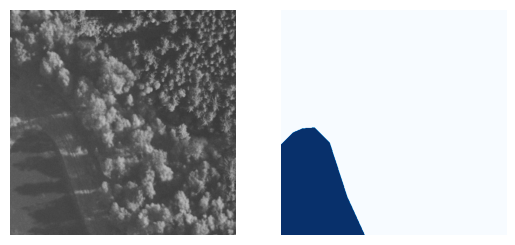

D:\DL DM\water\M-33-20-D-c-4-2_171_image.png


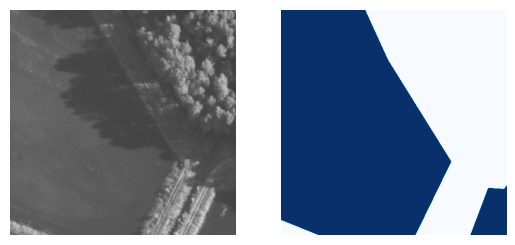

D:\DL DM\water\M-33-20-D-c-4-2_172_image.png


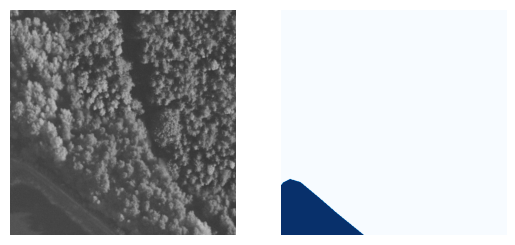

D:\DL DM\water\M-33-20-D-c-4-2_173_image.png


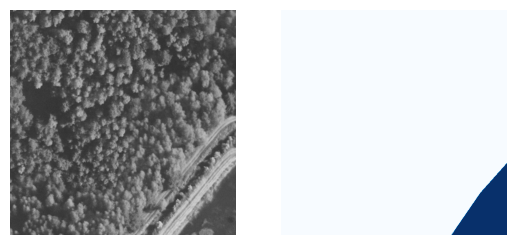

D:\DL DM\water\M-33-20-D-c-4-2_174_image.png


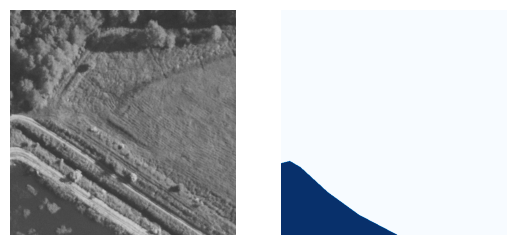

In [49]:
import matplotlib.image as mpimg
for i in range(5):
    image_path = water_images[i]
    mask_path = water_masks[i]
    print(image_path)
    
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    for i in range(500):
        for j in range(500):
            for k in range(3):
                if mask[i,j,k]==3:
                    mask[i,j,k]=1
                else:
                    mask[i,j,k]=0
            
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('Off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:,:,0], cmap='Blues')
    plt.axis('Off')
    plt.show()